<a href="https://colab.research.google.com/github/vinaykumar2491/Project_MachineLearning/blob/master/imflash217_flashai_6_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import gc
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 32

In [4]:
path = untar_data(url=URLs.PETS)
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [0]:
path_anno   = path/"annotations"
path_img    = path/"images"

## Data Augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.)

In [0]:
get_transforms??

In [8]:
src = (ImageList.from_folder(path_img)
                .split_by_rand_pct(0.2, seed=217))

src

ItemLists;

Train: ImageList (5912 items)
Image (3, 334, 500),Image (3, 375, 500),Image (3, 333, 500),Image (3, 333, 500),Image (3, 200, 241)
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: ImageList (1478 items)
Image (3, 500, 250),Image (3, 374, 500),Image (3, 500, 332),Image (3, 500, 375),Image (3, 357, 500)
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

In [0]:
def get_data(size, bs, padding_mode="reflection"):
    data = (src.label_from_re(r"([^/]+)_\d+.jpg$")
               .transform(tfms=tfms, size=size, padding_mode=padding_mode)
               .databunch(bs=bs)
               .normalize(imagenet_stats))
    return data
    

In [0]:
data = get_data(size=224, bs=bs, padding_mode="zeros")

In [20]:
data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Birman,samoyed,beagle,scottish_terrier,Egyptian_Mau
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Egyptian_Mau,american_bulldog,yorkshire_terrier,keeshond,leonberger
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

In [21]:
data.train_ds[0]

(Image (3, 224, 224), Category Birman)

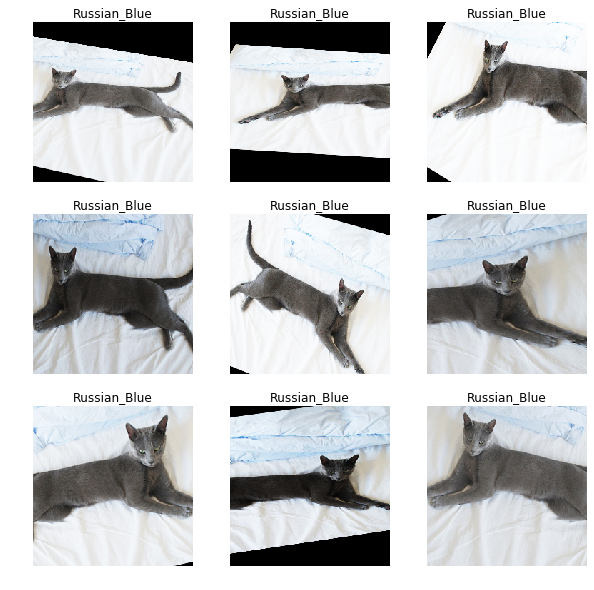

In [41]:
def _plot(i,j,ax):
    x, y = data.train_ds[217]
    x.show(ax, y=y)

plot_multi(func=_plot, r=3, c=3, figsize=(10,10))

In [0]:
data = get_data(size=224, bs=bs, padding_mode="reflection")

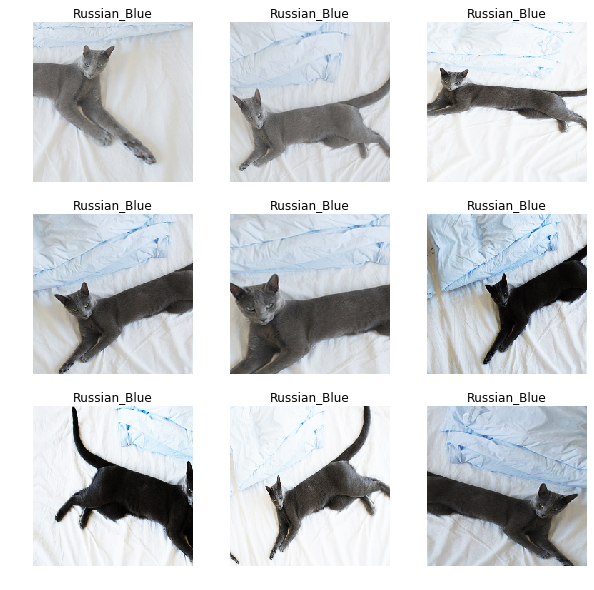

In [44]:
plot_multi(func=_plot, r=3, c=3, figsize=(10,10))

## Training a model

In [45]:
import gc
gc.collect()

46918

In [48]:
learner = cnn_learner(data=data, base_arch=models.resnet34, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 110MB/s]


In [50]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


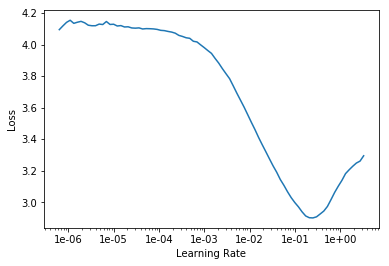

In [51]:
learner.lr_find()
learner.recorder.plot()

In [53]:
lr = slice(1e-2)
lr

slice(None, 0.01, None)

In [54]:
learner.fit_one_cycle(cyc_len=4, max_lr=lr, pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.573948,0.490061,0.081867,01:55
1,1.046688,0.292484,0.074425,01:56
2,0.876778,0.262877,0.075101,01:56
3,0.732665,0.219422,0.058863,01:56


In [0]:
learner.save("resnet34_stage1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


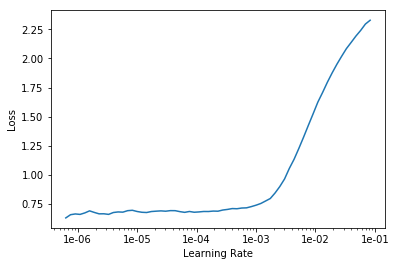

In [56]:
learner.unfreeze()

learner.lr_find()
learner.recorder.plot()

In [58]:
learner.fit_one_cycle(cyc_len=4, max_lr=slice(1e-6, 1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.658965,0.213714,0.052097,02:00
1,0.665400,0.198844,0.051421,02:02
2,0.607063,0.225378,0.065629,02:02
3,0.553643,0.191808,0.050744,02:02


In [0]:
learner.save("resnet34_stage2")

In [0]:
### fetching same dataset with new bigger image size
data = get_data(size=352, bs=bs, padding_mode="reflection")

### attaching this new to our learner model; so it can be trained with old weights on new data
learner.load("resnet34_stage2")
learner.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


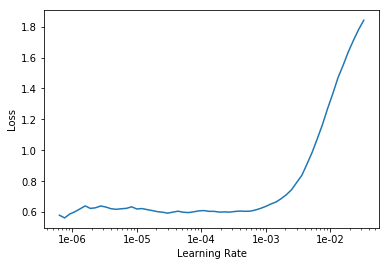

In [61]:
learner.lr_find()
learner.recorder.plot()

In [62]:
lrs = slice(1e-6, 5e-4)
lrs

slice(1e-06, 0.0005, None)

In [63]:
learner.fit_one_cycle(cyc_len=4, max_lr=lrs, pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.578485,0.197264,0.058187,03:37
1,0.522860,0.189730,0.050744,03:33
2,0.508260,0.167663,0.046685,03:31
3,0.465149,0.170650,0.050068,03:32


In [0]:
learner.save("resnet34_stage3_352")

## Convolutional Kernel

In [0]:
data = get_data(size=352, bs=bs)

Category Egyptian_Mau

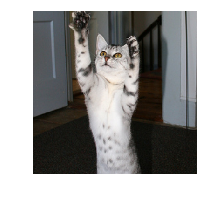

In [66]:
idx = 0
x, y = data.valid_ds[idx]
x.show()
y

In [67]:
data.valid_ds.y[idx]

Category Egyptian_Mau

In [69]:
### Convolutional Kernel
kernel = tensor([[0.,   -5/3,   1.],
                 [-5/3, -5/3,   1.],
                 [1.,   1.,     1.]])
kernel

tensor([[ 0.0000, -1.6667,  1.0000],
        [-1.6667, -1.6667,  1.0000],
        [ 1.0000,  1.0000,  1.0000]])

In [71]:
kernel.shape

torch.Size([3, 3])

In [0]:
kernel.expand??

In [72]:
kernel = kernel.expand(1,3,3,3)
kernel = kernel/6
kernel

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [73]:
kernel.shape

torch.Size([1, 3, 3, 3])

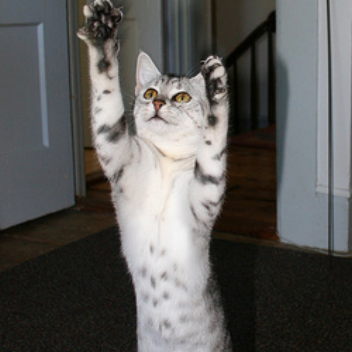

In [74]:
img = data.valid_ds[0][0]
img

In [75]:
img.shape

torch.Size([3, 352, 352])

In [76]:
img.data

tensor([[[0.3524, 0.3552, 0.3548,  ..., 0.6627, 0.6711, 0.6709],
         [0.3529, 0.3540, 0.3538,  ..., 0.6645, 0.6706, 0.6706],
         [0.3502, 0.3512, 0.3516,  ..., 0.6684, 0.6737, 0.6747],
         ...,
         [0.0943, 0.0840, 0.0791,  ..., 0.0772, 0.0902, 0.0992],
         [0.0874, 0.0871, 0.0914,  ..., 0.0767, 0.0876, 0.1005],
         [0.0824, 0.0979, 0.1102,  ..., 0.0833, 0.0854, 0.0955]],

        [[0.3725, 0.3728, 0.3759,  ..., 0.6780, 0.6856, 0.6854],
         [0.3725, 0.3725, 0.3758,  ..., 0.6727, 0.6788, 0.6788],
         [0.3698, 0.3708, 0.3745,  ..., 0.6688, 0.6735, 0.6745],
         ...,
         [0.0984, 0.0880, 0.0809,  ..., 0.0689, 0.0862, 0.0953],
         [0.0874, 0.0889, 0.0913,  ..., 0.0689, 0.0866, 0.0995],
         [0.0824, 0.0981, 0.1085,  ..., 0.0774, 0.0893, 0.0994]],

        [[0.3961, 0.4044, 0.4096,  ..., 0.6787, 0.6898, 0.6896],
         [0.3911, 0.3977, 0.4051,  ..., 0.6779, 0.6852, 0.6852],
         [0.3855, 0.3920, 0.4013,  ..., 0.6797, 0.6827, 0.

In [79]:
data.valid_ds[0]

(Image (3, 352, 352), Category Egyptian_Mau)

In [0]:
img_data = img.data

In [83]:
img_data.shape

torch.Size([3, 352, 352])

In [84]:
img_data[None].shape

torch.Size([1, 3, 352, 352])

In [85]:
edge = F.conv2d(input=img_data[None], weight=kernel)
edge

tensor([[[[ 2.4897e-05,  9.2691e-04, -2.3894e-03,  ...,  1.7281e-02,
            1.4870e-02,  1.3861e-05],
          [ 1.0689e-03,  3.1254e-03, -9.4347e-04,  ...,  1.4454e-02,
            1.4448e-02,  6.4298e-03],
          [ 1.4371e-02,  9.8446e-03,  3.6651e-03,  ...,  4.0435e-03,
            1.2801e-02,  1.3720e-02],
          ...,
          [-2.1227e-02, -5.6636e-03,  1.7329e-02,  ..., -5.9630e-02,
           -1.6096e-02,  1.6221e-03],
          [-1.4716e-02,  1.0997e-02,  2.7357e-02,  ...,  1.4411e-02,
            2.8515e-02,  1.5992e-02],
          [ 9.2290e-03,  3.0088e-02,  1.6637e-02,  ...,  5.6282e-02,
            4.7337e-02,  2.6324e-02]]]])

In [86]:
edge.shape

torch.Size([1, 1, 350, 350])

In [87]:
edge[0]

tensor([[[ 2.4897e-05,  9.2691e-04, -2.3894e-03,  ...,  1.7281e-02,
           1.4870e-02,  1.3861e-05],
         [ 1.0689e-03,  3.1254e-03, -9.4347e-04,  ...,  1.4454e-02,
           1.4448e-02,  6.4298e-03],
         [ 1.4371e-02,  9.8446e-03,  3.6651e-03,  ...,  4.0435e-03,
           1.2801e-02,  1.3720e-02],
         ...,
         [-2.1227e-02, -5.6636e-03,  1.7329e-02,  ..., -5.9630e-02,
          -1.6096e-02,  1.6221e-03],
         [-1.4716e-02,  1.0997e-02,  2.7357e-02,  ...,  1.4411e-02,
           2.8515e-02,  1.5992e-02],
         [ 9.2290e-03,  3.0088e-02,  1.6637e-02,  ...,  5.6282e-02,
           4.7337e-02,  2.6324e-02]]])

In [88]:
edge[0].shape

torch.Size([1, 350, 350])

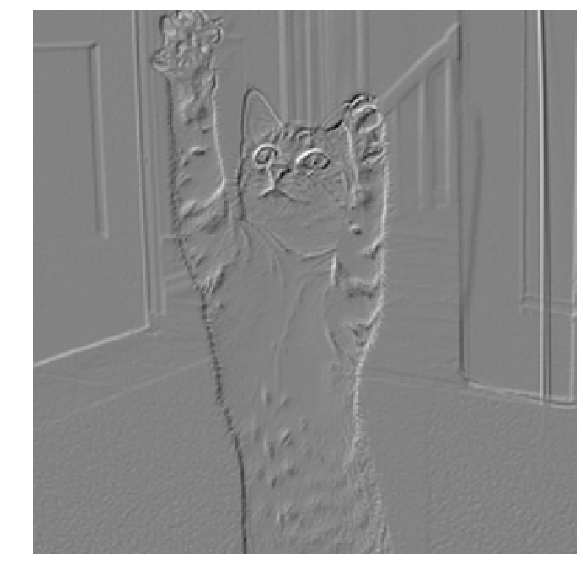

In [89]:
show_image(img=edge[0], figsize=(10,10))

## Heatmap

In [0]:
learner.load("resnet34_stage3_352")
model = learner.model

In [93]:
print(learner.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

In [0]:
idx = 0
x, y = data.valid_ds[idx]

In [0]:
xb, _ = data.one_item(x)
xb_img = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [135]:
xb

tensor([[[[-0.5792, -0.5670, -0.5687,  ...,  0.7760,  0.8126,  0.8117],
          [-0.5767, -0.5723, -0.5731,  ...,  0.7837,  0.8104,  0.8104],
          [-0.5886, -0.5843, -0.5826,  ...,  0.8008,  0.8240,  0.8283],
          ...,
          [-1.7062, -1.7511, -1.7725,  ..., -1.7810, -1.7242, -1.6845],
          [-1.7365, -1.7377, -1.7186,  ..., -1.7831, -1.7352, -1.6789],
          [-1.7583, -1.6905, -1.6366,  ..., -1.7540, -1.7452, -1.7010]],

         [[-0.3725, -0.3716, -0.3577,  ...,  0.9909,  1.0251,  1.0242],
          [-0.3725, -0.3725, -0.3579,  ...,  0.9672,  0.9945,  0.9945],
          [-0.3847, -0.3804, -0.3640,  ...,  0.9500,  0.9712,  0.9755],
          ...,
          [-1.5966, -1.6430, -1.6747,  ..., -1.7282, -1.6507, -1.6102],
          [-1.6458, -1.6391, -1.6283,  ..., -1.7282, -1.6493, -1.5917],
          [-1.6681, -1.5979, -1.5514,  ..., -1.6902, -1.6371, -1.5920]],

         [[-0.0441, -0.0070,  0.0160,  ...,  1.2118,  1.2615,  1.2606],
          [-0.0663, -0.0371, -

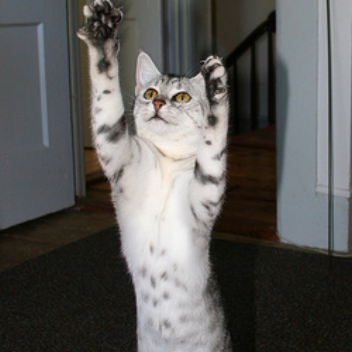

In [136]:
xb_img

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(category):
    with hook_output(model[0]) as hook_activations:
        with hook_output(model[0], grad=True) as hook_gradients:
            predictions = model(xb)
            predictions[0, int(category)].backward()
    return hook_activations, hook_gradients

In [0]:
hook_activations, hook_gradients = hooked_backward(category=y)

In [117]:
hook_activations

In [118]:
hook_gradients

In [0]:
activations = hook_activations.stored[0]

In [124]:
activations

tensor([[[0.0433, 0.0000, 0.0000,  ..., 0.3981, 0.2074, 0.1760],
         [0.2939, 0.0000, 0.0000,  ..., 0.6791, 0.3621, 0.5572],
         [0.3023, 0.0173, 0.2982,  ..., 1.3598, 0.8235, 0.7345],
         ...,
         [0.8078, 0.7021, 1.8100,  ..., 1.8139, 0.0938, 0.2104],
         [1.2160, 0.5601, 0.8579,  ..., 1.9444, 0.3712, 0.6485],
         [0.6469, 0.6924, 0.9277,  ..., 1.2029, 0.4891, 0.8071]],

        [[0.0000, 0.3756, 1.2718,  ..., 0.0000, 0.0000, 0.0000],
         [0.3373, 1.4933, 1.4747,  ..., 0.2209, 0.0000, 0.0000],
         [0.5625, 1.8697, 1.9377,  ..., 0.5281, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0517, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.4875, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.6947, 0.0000, 0.

In [126]:
activations.device

device(type='cuda', index=0)

In [0]:
activations = activations.cpu()

In [128]:
activations.device

device(type='cpu')

In [129]:
activations.shape

torch.Size([512, 11, 11])

In [130]:
xb.shape

torch.Size([1, 3, 352, 352])

In [131]:
avg_activations = activations.mean(dim=0)
avg_activations.shape

torch.Size([11, 11])

In [0]:
def show_heatmap(heatmap, img):
    _, ax = plt.subplots()
    img.show(ax)
    ax.imshow(heatmap, alpha=0.6, extent=(0,352,352,0), interpolation="bilinear", cmap="magma");

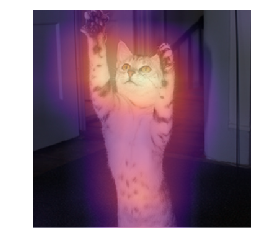

In [139]:
show_heatmap(heatmap=avg_activations, img=xb_img)

## Grad-CAM
```
Grad-CAM: Visual Explanations from Deep Networks via Gradient based Localizations
```

https://arxiv.org/abs/1610.02391

In [142]:
grad = hook_gradients.stored[0][0].cpu()
grad_per_channel = grad.mean(dim=1).mean(dim=1)
grad.shape, grad_per_channel.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [144]:
grad_per_channel[..., None, None].shape

torch.Size([512, 1, 1])

In [145]:
activations.shape

torch.Size([512, 11, 11])

In [146]:
(activations*grad_per_channel[..., None, None]).shape

torch.Size([512, 11, 11])

In [147]:
mult_acts_grad = (activations*grad_per_channel[..., None, None]).mean(0)
mult_acts_grad.shape

torch.Size([11, 11])

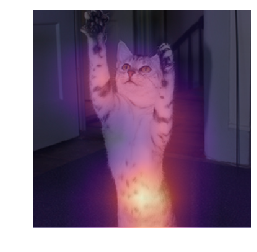

In [148]:
show_heatmap(heatmap=mult_acts_grad, img=xb_im)

In [153]:
hook_gradients.stored[0].shape

torch.Size([1, 512, 11, 11])

In [154]:
hook_activations.stored[0].shape

torch.Size([512, 11, 11])